In [1]:
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

file_list = glob.glob('./data/*.csv') 
df = pd.DataFrame()

for f in file_list:
    df_tmp = pd.read_csv(f)
    i = f.find('cy')
    df_tmp['year'] = f[i+2:i+6]
    i = f.find('\\')
    df_tmp['sex'] = f[i+1]
    df = pd.concat([df, df_tmp],ignore_index=True)

In [2]:
df.head()

,Given Name,Amount,Position,year,sex
0,MARGARET,341,1,1944,f
1,HELEN,209,2,1944,f
2,JUDITH,189,3,1944,f
3,PATRICIA,186,4,1944,f
4,PAMELA,160,5,1944,f


In [3]:
df.drop('Position', axis=1, inplace=True)

In [4]:
df.head()

,Given Name,Amount,year,sex
0,MARGARET,341,1944,f
1,HELEN,209,1944,f
2,JUDITH,189,1944,f
3,PATRICIA,186,1944,f
4,PAMELA,160,1944,f


In [5]:
dups = df[df.duplicated(['Given Name','year'],keep=False)].groupby(['Given Name','year']).Amount.sum()

In [6]:
df_dup = dups.to_frame()

In [7]:
df_dup.head()

Amount
Given Name year        
(NOT       1968       8
AARON      1963       8
           1966       7
           1968      21
           1969      10

In [8]:
df.shape[0]

151584

In [9]:
df.duplicated(['Given Name','year'],keep=False).value_counts()

False    143366
True       8218
dtype: int64

In [10]:
df.drop_duplicates(['Given Name','year'],inplace=True)

In [11]:
df.duplicated(['Given Name','year'],keep=False).value_counts()

False    147373
dtype: int64

In [12]:
df_dup.reset_index(level=['Given Name', 'year'], inplace=True) #convert index into columns
df_dup.head()

,Given Name,year,Amount
0,(NOT,1968,8
1,AARON,1963,8
2,AARON,1966,7
3,AARON,1968,21
4,AARON,1969,10


In [13]:
df2 = pd.merge(df, df_dup, on=['Given Name','year'], how='left')

In [14]:
df2.head()

,Given Name,Amount_x,year,sex,Amount_y
0,MARGARET,341,1944,f,343.0
1,HELEN,209,1944,f,NaN
2,JUDITH,189,1944,f,NaN
3,PATRICIA,186,1944,f,NaN
4,PAMELA,160,1944,f,NaN


In [15]:
df2.shape[0]

147373

In [16]:
#this is like an if then assign to specific column
df2.loc[df2.Amount_y.isnull(), 'Amount_y'] = df2['Amount_x']

In [17]:
df2.head()

,Given Name,Amount_x,year,sex,Amount_y
0,MARGARET,341,1944,f,343.0
1,HELEN,209,1944,f,209.0
2,JUDITH,189,1944,f,189.0
3,PATRICIA,186,1944,f,186.0
4,PAMELA,160,1944,f,160.0


In [18]:
df2.drop('Amount_x', axis=1, inplace=True)

In [19]:
df2.Amount_y = df2.Amount_y.astype(int)
df2.head()

,Given Name,year,sex,Amount_y
0,MARGARET,1944,f,343
1,HELEN,1944,f,209
2,JUDITH,1944,f,189
3,PATRICIA,1944,f,186
4,PAMELA,1944,f,160


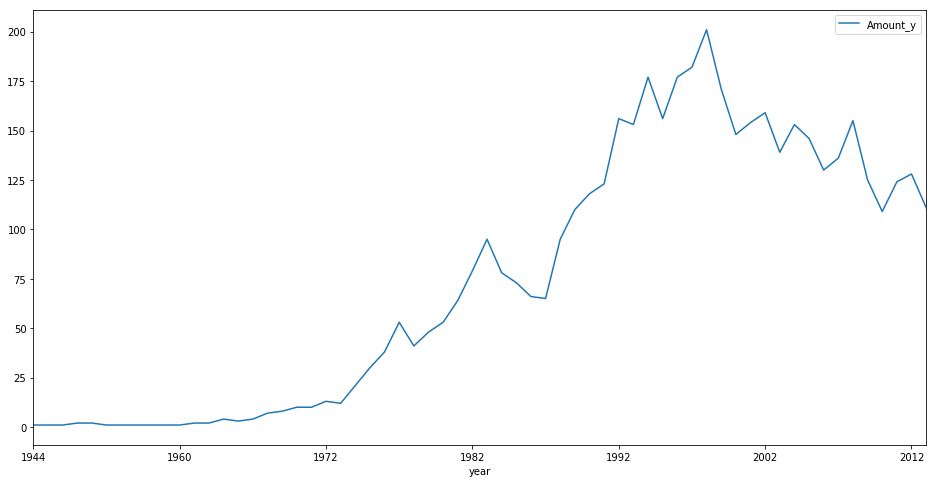

In [39]:
#plot takes the index as the x value and uses any numeric column as the y
df2.loc[df2['Given Name']=='EMILY'].sort_values('year').set_index('year').plot(figsize=(16,8))

In [ ]:
df.to_csv("all_names.csv")

you need to merge rows if name is the same!!!